![zad1.png](images/note5/zad1.png)

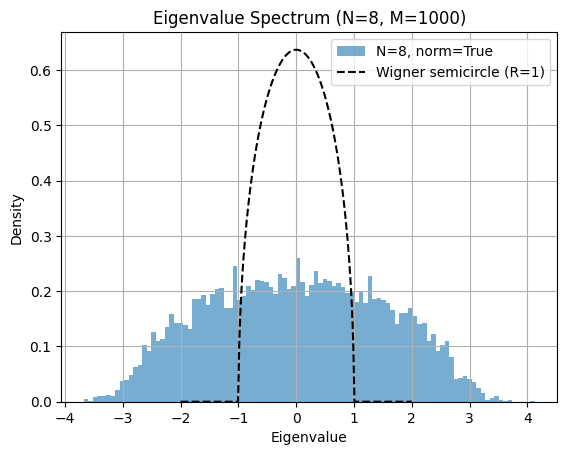

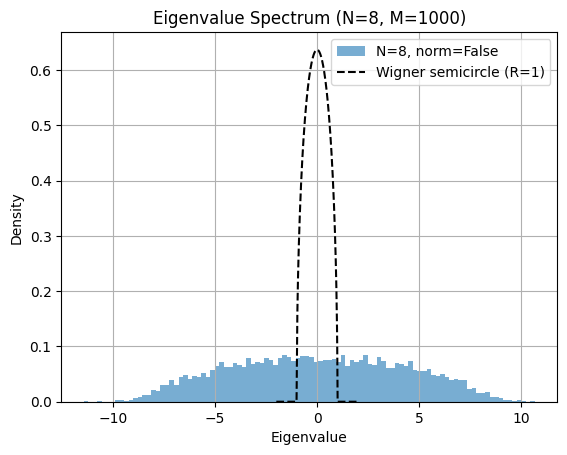

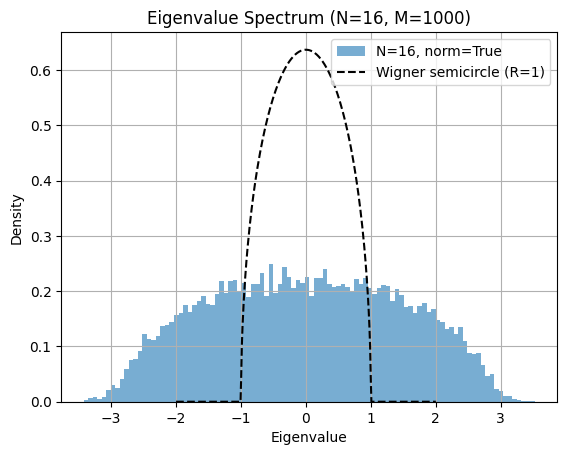

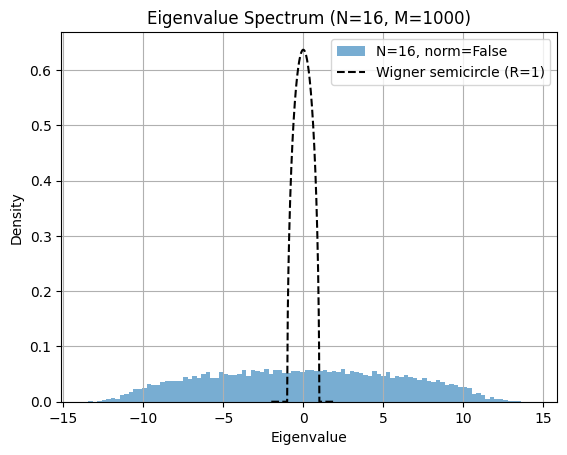

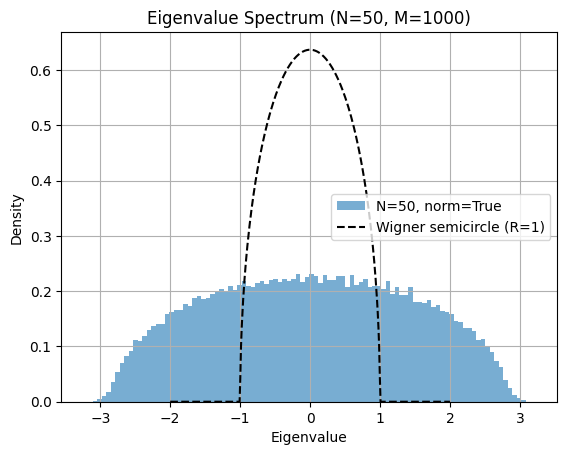

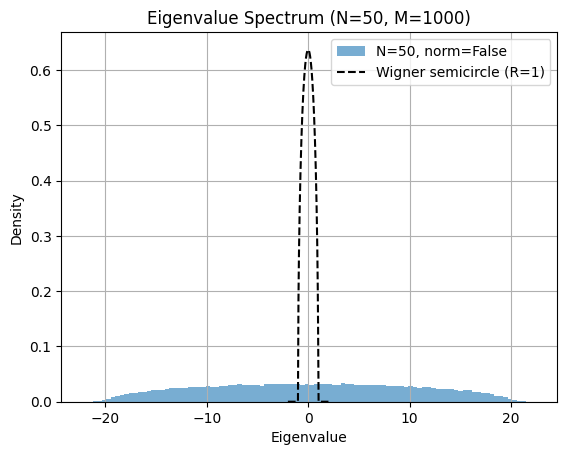

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def generate_goe_matrix(N, sigma=2):
    M = np.random.normal(loc=0, scale=sigma, size=(N, N))
    X = (M + M.T) / (2 * np.sqrt(N))
    return X

def wigner_semicircle(x, R=1, N=1):
    mask = abs(x) <= R
    result = np.zeros_like(x)
    result[mask] = (2 / (np.pi * R**2)) * np.sqrt(R**2 - x[mask]**2)
    return result

def plot_spectrum(N, M=1000, normalize=True):
    eigenvalues = []
    for _ in range(M):
        M_random = np.random.normal(0, 2, (N, N))
        sym_matrix = (M_random + M_random.T)
        if normalize:
            sym_matrix /= (2 * np.sqrt(N))
        else:
            sym_matrix /= 2
        eigenvalues.extend(np.linalg.eigvalsh(sym_matrix))

    plt.hist(eigenvalues, bins=100, density=True, alpha=0.6, label=f"N={N}, norm={normalize}")

    x = np.linspace(-2, 2, 400)
    plt.plot(x, wigner_semicircle(x, R=1), 'k--', label='Wigner semicircle (R=1)')

    plt.title(f"Eigenvalue Spectrum (N={N}, M={M})")
    plt.xlabel("Eigenvalue")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()

# Run for different N values
for N in [8, 16, 50]:
    plot_spectrum(N, M=1000, normalize=True)   # With normalization
    plot_spectrum(N, M=1000, normalize=False)  # Without normalization


![zad2.png](images/note5/zad2.png)

In [ ]:
import math

def compute_moments(N, M=1000, max_order=10, sigma=2):
    moments = np.zeros(max_order)
    for _ in range(M): # iterates over M where M is the number of matrices
        X = generate_goe_matrix(N, sigma=sigma)
        eigvals = np.linalg.eigvalsh(X) # generates N eigvals
        for k in range(1, max_order + 1):
            moments[k - 1] += np.mean(eigvals**k)
    moments /= M # constains means of the first 10 moments of 1000 matrices
    return moments

def wigner_analytic_moments(max_order=10):
    moments = []
    for k in range(1, max_order + 1):
        if k % 2 == 1:
            moments.append(0)  # odd moments are zero
        else:
            n = k // 2
            catalan = math.factorial(2 * n) // (math.factorial(n) * math.factorial(n + 1))
            moments.append(catalan)
    return moments

N = 50 # size of matrix
M_samples = 1000 # number of matrices
max_order = 10 # number of moments

# brute-force spectral moments
brute_force_moments = compute_moments(N=N, M=M_samples, max_order=max_order)

# wigner semicircle moments
analytic_moments = wigner_analytic_moments(max_order=max_order)

print(f"{'k':>2}  {'Brute-force':>15}  {'Analytic (Wigner)':>20}")
print("=" * 40)
for k in range(1, max_order + 1):
    bf = brute_force_moments[k - 1]
    an = analytic_moments[k - 1]
    print(f"{k:>2}  {bf:15.6f}  {an:20.6f}")

 k      Brute-force     Analytic (Wigner)
 1         0.002044              0.000000
 2         2.038358              1.000000
 3         0.013213              0.000000
 4         8.386771              2.000000
 5         0.089698              0.000000
 6        43.490273              5.000000
 7         0.591158              0.000000
 8       254.533067             14.000000
 9         3.755261              0.000000
10      1608.096400             42.000000
